In [1]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINet
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

ModuleNotFoundError: No module named 'gaminet'

## Load data

In [5]:


%run "gamilstm.py"
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator(datanum, dist="uniform", random_state=0):

    nfeatures = 8
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4)
        + cliff(x5, x6)).reshape([-1,1]) + 3 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    # train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    w= np.ones(len(x))
    return x, y, w , task_type, meta_info, metric_wrapper(rmse, sy)

random_state = 0
train_x, train_y, train_w, task_type, meta_info, get_metric = data_generator(datanum=20000, random_state=random_state)

valids=2
Valid_X=[]
Valid_Y=[]
Valid_W=[]
for i in range(valids):
    x,y,w, task_type, meta_info, get_metric = data_generator(datanum=2000, random_state=random_state+i)    
    Valid_X.append(x)
    Valid_Y.append(y)
    Valid_W.append(w)

test_x, test_y, test_w, task_type, meta_info, get_metric = data_generator(datanum=2000, random_state=random_state)
train_x.shape,test_x.shape,

((20000, 8), (2000, 8))

## Train GAMI-Net 

In [6]:
%%time
%run "gamilstm.py"
self = GAMINet(meta_info=meta_info, interact_num=10, 
                interact_arch=[10] * 1, subnet_arch=[20] * 1, 
                batch_size=1000, task_type=task_type, activation_func=tf.nn.relu, 
                epochs = [50, 50, 50],
                training=[True,False,False],
                lr_bp=[0.0001, 0.0001, 0.0001], 
                early_stop_thres=[-5, 5, 5],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                verbose=True, val_ratio=0.2, random_state=random_state)
self.fit(train_x, train_y, train_w, Valid_X,Valid_Y,Valid_W)


####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.22503066062927246, val loss: [0.23000008 0.17015223]
Main effects training epoch: 2, train loss: 0.20274747908115387, val loss: [0.20767884 0.1515449 ]
Main effects training epoch: 3, train loss: 0.1825793981552124, val loss: [0.18746342 0.13490732]
Main effects training epoch: 4, train loss: 0.16437089443206787, val loss: [0.16919562 0.12008224]
Main effects training epoch: 5, train loss: 0.1478481888771057, val loss: [0.15260276 0.10682326]
Main effects training epoch: 6, train loss: 0.13286449015140533, val loss: [0.13753882 0.09499256]
Main effects training epoch: 7, train loss: 0.11924716830253601, val loss: [0.12383428 0.08443341]
Main effects training epoch: 8, train loss: 0.10690761357545853, val loss: [0.11140023 0.07506088]
Main effects training epoch: 9, train loss: 0.09577316045761108, val loss: [0.10016485 0

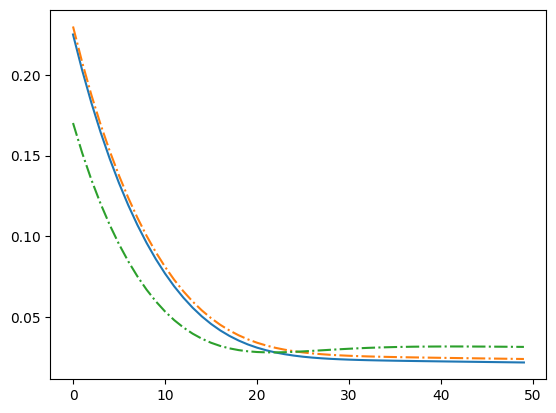

In [8]:
plt.plot(self.err_train_main_effect_training)
for i in range(valids):
    plt.plot(self.err_val_main_effect_training[:,i],ls="-.")


In [232]:
maineffect_outputs = self.MainEffectBlock.call(train_x, train_w, training=False)
main_effect_switcher = self.OutputLayer.main_effect_switcher.value
output=self.OutputLayer(tf.transpose(main_effect_switcher)*maineffect_outputs).numpy()[:,0]


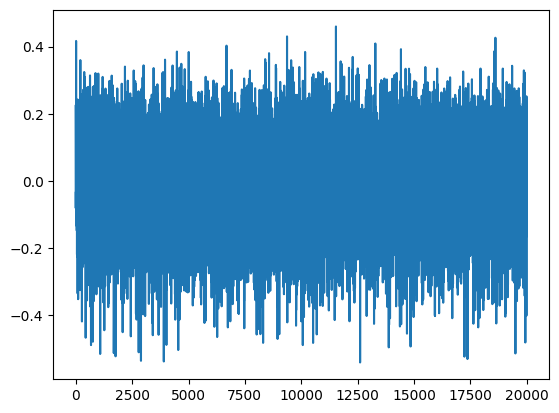

In [233]:
plt.plot((output-train_y[:,0]))

In [12]:
scaled_data

array([[0.56509299],
       [0.56509299],
       [0.77110157],
       ...,
       [0.61373391],
       [0.61373391],
       [0.61373391]])

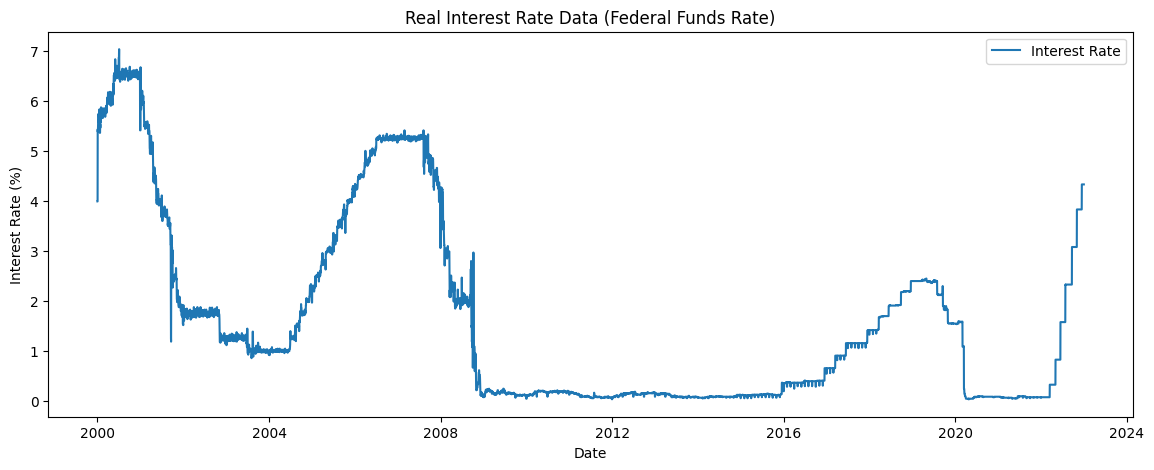

Epoch 1/20


c:\Users\Giwa\.conda\envs\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0114 - val_loss: 2.8262e-04
Epoch 2/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0012 - val_loss: 2.6514e-04
Epoch 3/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 9.6680e-04 - val_loss: 4.6087e-04
Epoch 4/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 9.4357e-04 - val_loss: 3.2008e-04
Epoch 5/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 8.6500e-04 - val_loss: 2.2774e-04
Epoch 6/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 8.5239e-04 - val_loss: 2.5227e-04
Epoch 7/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 8.0562e-04 - val_loss: 2.0129e-04
Epoch 8/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 8.0331e-04 - val_loss: 2.0484e-04
Epoch 9/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 8.5415e-04 - val_loss: 2.2384e-04
Epoch 10/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 7.9545e-04 - val_loss: 1.9823e-04
Epoch 11/20
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 7.7914

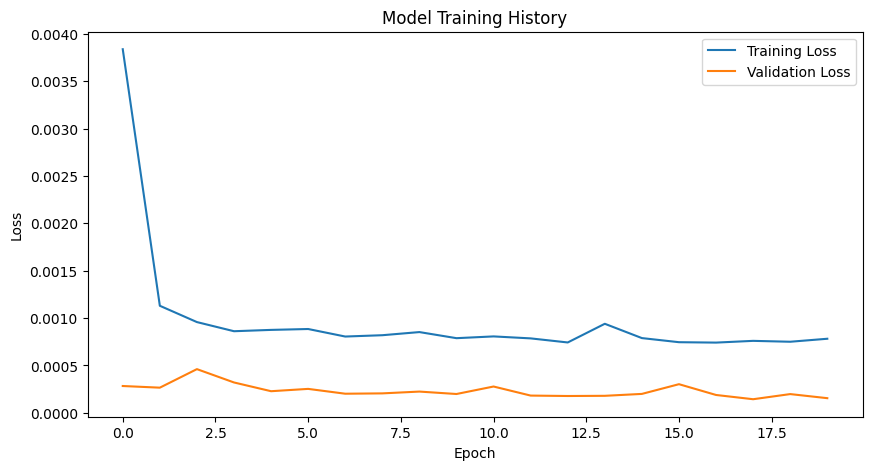

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


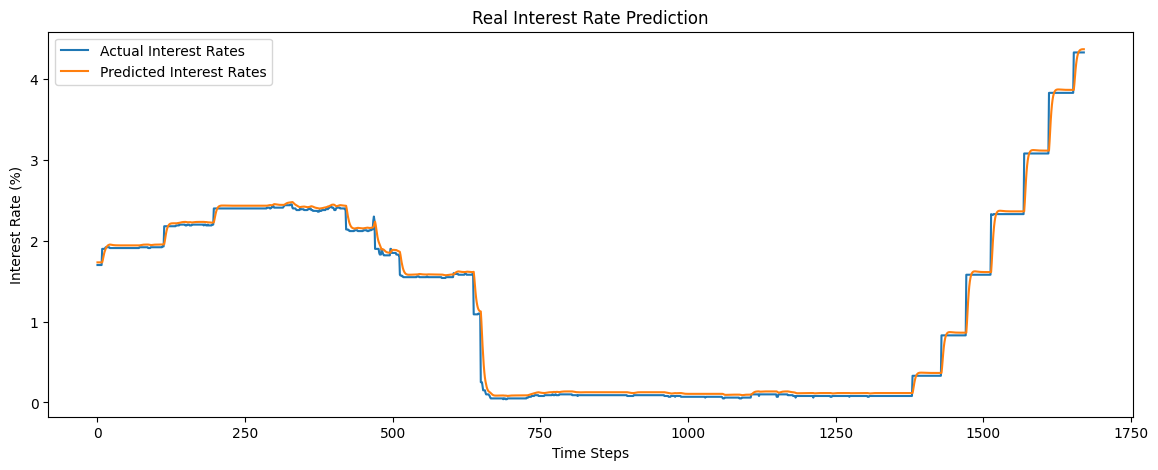

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Layer
from pandas_datareader.data import DataReader

# Load real-world interest rate data
def load_real_interest_rate_data(start_date, end_date):
    """
    Fetch real-world interest rate data from FRED (Federal Reserve Economic Data).
    Args:
    - start_date: Start date (YYYY-MM-DD).
    - end_date: End date (YYYY-MM-DD).
    Returns:
    - DataFrame with interest rate data.
    """
    symbol = "DFF"  # Daily Federal Funds Rate from FRED
    df = DataReader(symbol, data_source="fred", start=start_date, end=end_date)
    df = df.rename(columns={"DFF": "InterestRate"}).dropna()
    return df

# Fetch data
start_date = "2000-01-01"
end_date   = "2023-01-01"
data       = load_real_interest_rate_data(start_date, end_date)

# Visualize the data
plt.figure(figsize=(14, 5))
plt.plot(data.index, data["InterestRate"], label="Interest Rate")
plt.title("Real Interest Rate Data (Federal Funds Rate)")
plt.xlabel("Date")
plt.ylabel("Interest Rate (%)")
plt.legend()
plt.show()

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data["InterestRate"].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 50
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Make predictions
predicted_rates = model.predict(X_test)
predicted_rates = scaler.inverse_transform(predicted_rates)
actual_rates = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualize predictions vs actual
plt.figure(figsize=(14, 5))
plt.plot(range(len(actual_rates)), actual_rates, label="Actual Interest Rates")
plt.plot(range(len(predicted_rates)), predicted_rates, label="Predicted Interest Rates")
plt.title("Real Interest Rate Prediction")
plt.xlabel("Time Steps")
plt.ylabel("Interest Rate (%)")
plt.legend()
plt.show()


In [ ]:
class LSTMNet(tf.keras.layers):
    def __init__(self, subnet_arch, activation_func, subnet_id):
        super(NumerNet, self).__init__()
        self.layers = []
        self.subnet_arch = subnet_arch
        self.activation_func = activation_func
        self.subnet_id = subnet_id
        for nodes in self.subnet_arch:
            self.layers.append(layers.Dense(nodes, activation=self.activation_func, kernel_initializer=tf.keras.initializers.Orthogonal()))
        self.output_layer = layers.Dense(1, activation=tf.identity, kernel_initializer=tf.keras.initializers.Orthogonal())
        self.min_value = self.add_weight(name="min" + str(self.subnet_id), shape=[1], initializer=tf.constant_initializer(np.inf), trainable=False)
        self.max_value = self.add_weight(name="max" + str(self.subnet_id), shape=[1], initializer=tf.constant_initializer(-np.inf), trainable=False)
        self.moving_mean = self.add_weight(name="mean" + str(self.subnet_id), shape=[1], initializer=tf.zeros_initializer(), trainable=False)
        self.moving_norm = self.add_weight(name="norm" + str(self.subnet_id), shape=[1], initializer=tf.ones_initializer(), trainable=False)

    def call(self, inputs, sample_weight=None, training=False):
        if training:
            self.min_value.assign(tf.minimum(self.min_value, tf.reduce_min(inputs)))
            self.max_value.assign(tf.maximum(self.max_value, tf.reduce_max(inputs)))
        x = tf.clip_by_value(inputs, self.min_value, self.max_value)
        for dense_layer in self.layers:
            x = dense_layer(x)
        self.output_original = self.output_layer(x)
        if training:
            if sample_weight is None:
                if inputs.shape[0] is not None:
                    sample_weight = tf.ones([inputs.shape[0], 1])
                    self.subnet_mean, self.subnet_norm = tf.nn.weighted_moments(self.output_original,  frequency_weights=sample_weight, axes=0)
            else:
                sample_weight = tf.reshape(sample_weight, shape=(-1, 1))
                self.subnet_mean, self.subnet_norm = tf.nn.weighted_moments(self.output_original,  frequency_weights=sample_weight, axes=0)
            self.moving_mean.assign(self.subnet_mean)
            self.moving_norm.assign(self.subnet_norm)
        else:
            self.subnet_mean = self.moving_mean
            self.subnet_norm = self.moving_norm
        output = self.output_original
        return output

In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Function to generate synthetic data with multiple features
def generate_multifeature_data(seq_length=50, n_samples=1000, n_features=6):

    # Generate synthetic features
    t = np.linspace(0, n_samples / 10, n_samples)
    data = np.zeros((n_samples, n_features))
    
    # Create patterns for each feature
    data[:, 0] = np.sin(t/4)+2*np.random.uniform(0,1,n_samples)   +0.025*t                     # Sine wave
    data[:, 1] = np.cos(t) +2*np.random.uniform(0,1,n_samples)                          # Cosine wave
    data[:, 2] = np.linspace(0, 1, n_samples) +2*np.random.uniform(0,1,n_samples)      # Linear trend
    data[:, 3] = np.random.uniform(0, 1, n_samples) +2*np.random.uniform(0,1,n_samples)   # Random noise
    data[:, 4] = np.sin(2 * t)   +2*np.random.uniform(0,1,n_samples)                   # Sine wave with double frequency
    data[:, 5] = 0.5 * np.cos(2 * t)   +2*np.random.uniform(0,1,n_samples)             # Cosine wave with half amplitude

    # Normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    # Prepare sequences
    X, y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i + seq_length])  # Sequence of features
        y.append(data_scaled[i + seq_length, 0])  # Predict next value of the first feature
    
    return np.array(X), np.array(y), data, scaler

# Generate data
seq_length = 50
n_features = 6
X, y, data, scaler = generate_multifeature_data(seq_length=seq_length, n_samples=1000, n_features=n_features)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# for i in range(6):
#     plt.plot(data[:,i])
#     plt.show()


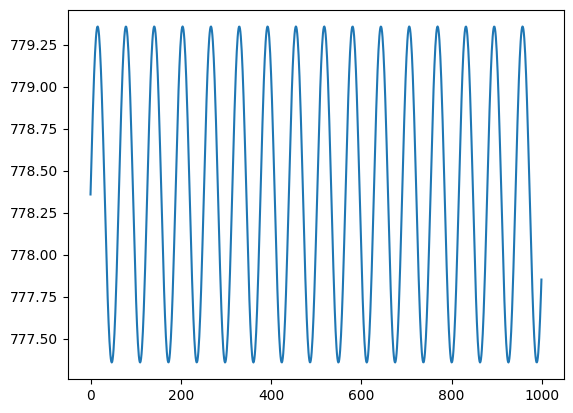

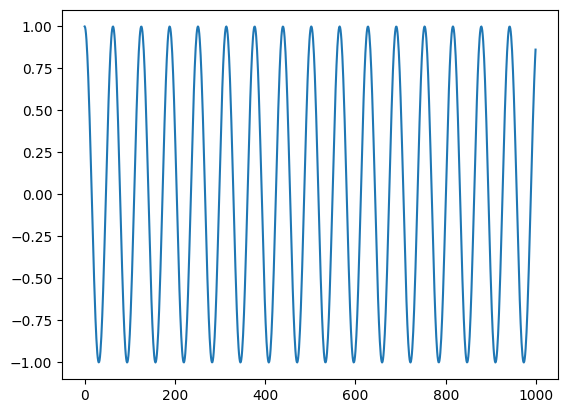

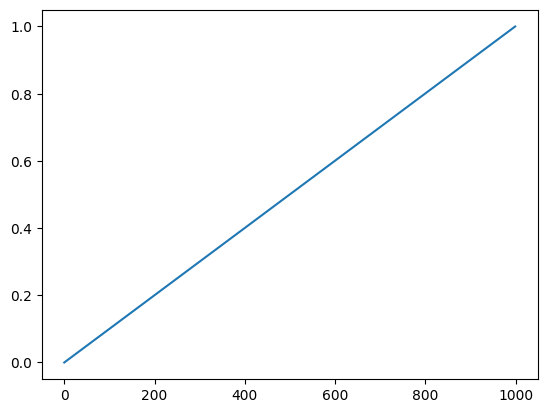

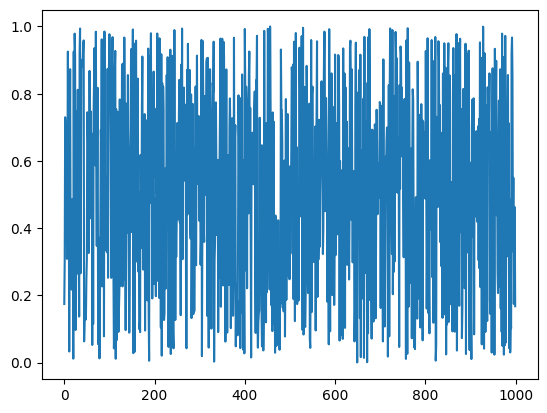

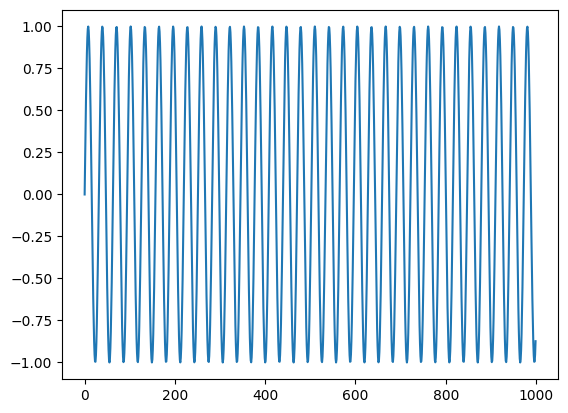

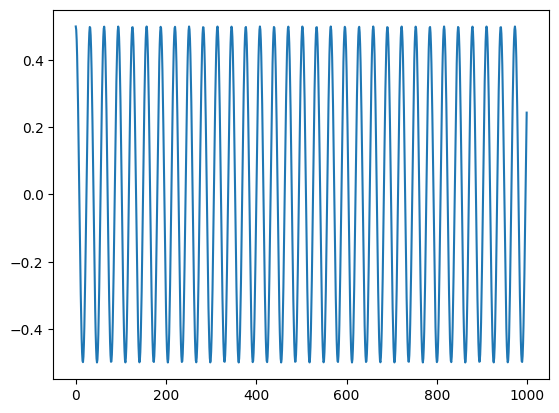

In [ ]:

# Visualize one feature for inspection
plt.figure(figsize=(12, 6))
plt.plot(range(len(y)), scaler.inverse_transform(np.column_stack([y, np.zeros_like(y), np.zeros_like(y)]))[:, 0], label="Feature 1 (Sine wave)")
plt.title("Synthetic Multi-Feature Data (First Feature Visualization)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.show()

# Print shapes
print(f"X_train shape: {X_train.shape} (Samples, Sequence Length, Features)")
print(f"y_train shape: {y_train.shape} (Samples, Target)")
print(f"X_test shape: {X_test.shape} (Samples, Sequence Length, Features)")
print(f"y_test shape: {y_test.shape} (Samples, Target)")


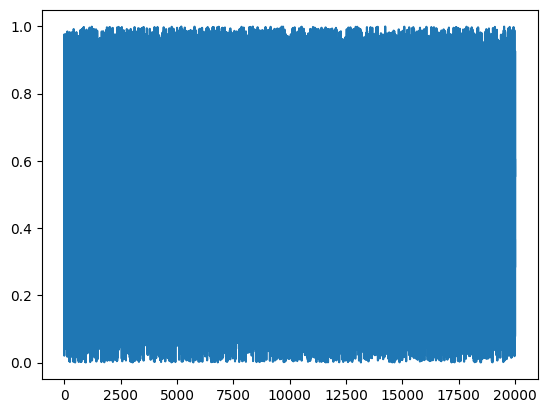

In [13]:
plt.plot(train_x[:,0])

In [40]:
def call(self, inputs, sample_weight=None, main_effect_training=False, interaction_training=False):

    self.clarity_loss = tf.constant(0.0)
    self.maineffect_outputs = self.maineffect_blocks(inputs, sample_weight, training=main_effect_training)
    if self.interaction_status:
        self.interact_outputs = self.interact_blocks(inputs, sample_weight, training=interaction_training)
        main_weights = tf.multiply(self.output_layer.main_effect_switcher, self.output_layer.main_effect_weights)
        interaction_weights = tf.multiply(self.output_layer.interaction_switcher, self.output_layer.interaction_weights)
        for i, (k1, k2) in enumerate(self.interaction_list):
            a1 = tf.multiply(tf.gather(self.maineffect_outputs, [k1], axis=1), tf.gather(main_weights, [k1], axis=0))
            a2 = tf.multiply(tf.gather(self.maineffect_outputs, [k2], axis=1), tf.gather(main_weights, [k2], axis=0))
            b = tf.multiply(tf.gather(self.interact_outputs, [i], axis=1), tf.gather(interaction_weights, [i], axis=0))
            if sample_weight is not None:
                self.clarity_loss += tf.abs(tf.reduce_mean(tf.multiply(tf.multiply(a1, b), tf.reshape(sample_weight, (-1, 1)))))
                self.clarity_loss += tf.abs(tf.reduce_mean(tf.multiply(tf.multiply(a2, b), tf.reshape(sample_weight, (-1, 1)))))
            else:
                self.clarity_loss += tf.abs(tf.reduce_mean(tf.multiply(a1, b)))
                self.clarity_loss += tf.abs(tf.reduce_mean(tf.multiply(a2, b)))
    else:
        self.interact_outputs = tf.zeros([inputs.shape[0], self.interact_num])

    concat_list = [self.maineffect_outputs]
    if self.interact_num > 0:
        concat_list.append(self.interact_outputs)

    if self.task_type == "Regression":
        output = self.output_layer(tf.concat(concat_list, 1))
    elif self.task_type == "Classification":
        output = tf.nn.sigmoid(self.output_layer(tf.concat(concat_list, 1)))
    else:
        raise ValueError("The task type is not supported")

    return output

@tf.function
def predict_graph(self, x, main_effect_training=False, interaction_training=False):
    return call(self, x, sample_weight=None,
                    main_effect_training=main_effect_training,
                    interaction_training=interaction_training)

def predict(self, x):
    return predict_graph(self, tf.cast(x, tf.float32)).numpy()

val_x = train_x[self.val_idx, :]
val_y = train_y[self.val_idx, :]
val_w = train_w[self.val_idx]

tr_x = train_x[self.tr_idx, :]
tr_y = train_y[self.tr_idx, :]

inputs= tf.cast(val_x, tf.float32)
sample_weight=val_w
main_effect_training=False
self.maineffect_outputs = self.maineffect_blocks(inputs, sample_weight, training=main_effect_training)

In [39]:
self.val_idx

array([299, 500, 303,  40, 495, 436, 236, 605, 389, 231,  14, 240, 781,
       794,  27,  55, 344, 222, 162, 478, 669, 113, 682, 521, 776, 465,
       156, 247, 440, 613, 520, 590,  85, 530, 267,  31, 278, 619, 685,
       790, 578, 796, 791, 622, 451, 401, 473, 447, 103, 688, 667, 570,
       258,  75, 788, 577, 283, 239, 780, 786, 717,   8, 573, 604, 145,
       230, 301, 142, 261, 235, 453, 701,   1, 331, 499,  79, 691, 626,
       435, 797, 251, 250, 390, 703, 386, 536, 652, 736, 362, 403, 745,
       122, 333, 513, 490, 413, 582, 700, 741, 252, 502, 408, 372, 609,
        18, 215, 650, 454, 493, 202, 711,  50, 692, 768, 695, 580, 402,
        39, 200, 210, 475, 175,  10, 419,  68, 476, 242, 634, 468, 415,
       572, 457,   2, 792, 793, 150, 196, 687, 739, 728, 441, 399, 724,
       363, 263, 418, 249,  71,  49, 766, 642, 116,  37, 432,  48, 193,
       337, 310, 266, 243])

In [ ]:

pred_train = predict(self,tr_x)

In [12]:
not True

False

In [9]:
val_x

array([[0.69684604, 0.98980409, 0.99087462, ..., 0.86206001, 0.25355482,
        0.60104516],
       [0.67591355, 0.84233853, 0.81759692, ..., 0.40691732, 0.74006873,
        0.96877876],
       [0.44736762, 0.89758608, 0.30246692, ..., 0.75636197, 0.31359174,
        0.03004835],
       ...,
       [0.77769598, 0.10129986, 0.1457809 , ..., 0.301381  , 0.77353287,
        0.91771534],
       [0.37071164, 0.13823707, 0.54337431, ..., 0.19115656, 0.77935211,
        0.64176198],
       [0.87017245, 0.92992277, 0.2329053 , ..., 0.9224163 , 0.24469877,
        0.20382199]])

In [ ]:

pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5), 
                      np.round(get_metric(val_y, pred_val),5),
                      np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

## Visualization

In [ ]:
pi

In [4]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

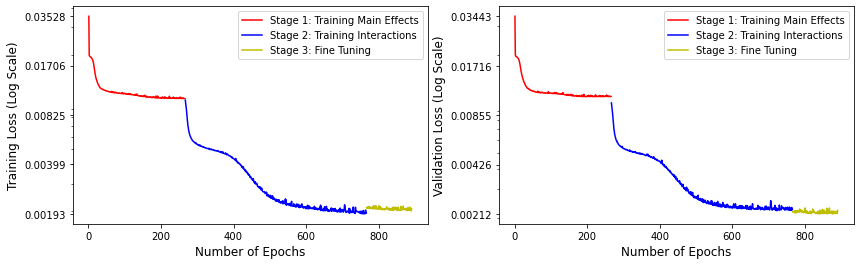

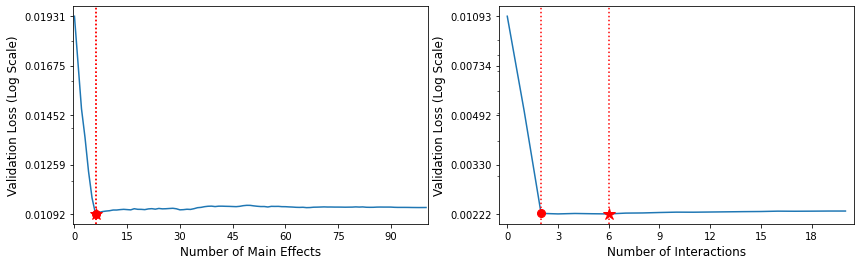

In [5]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

Global Visualization

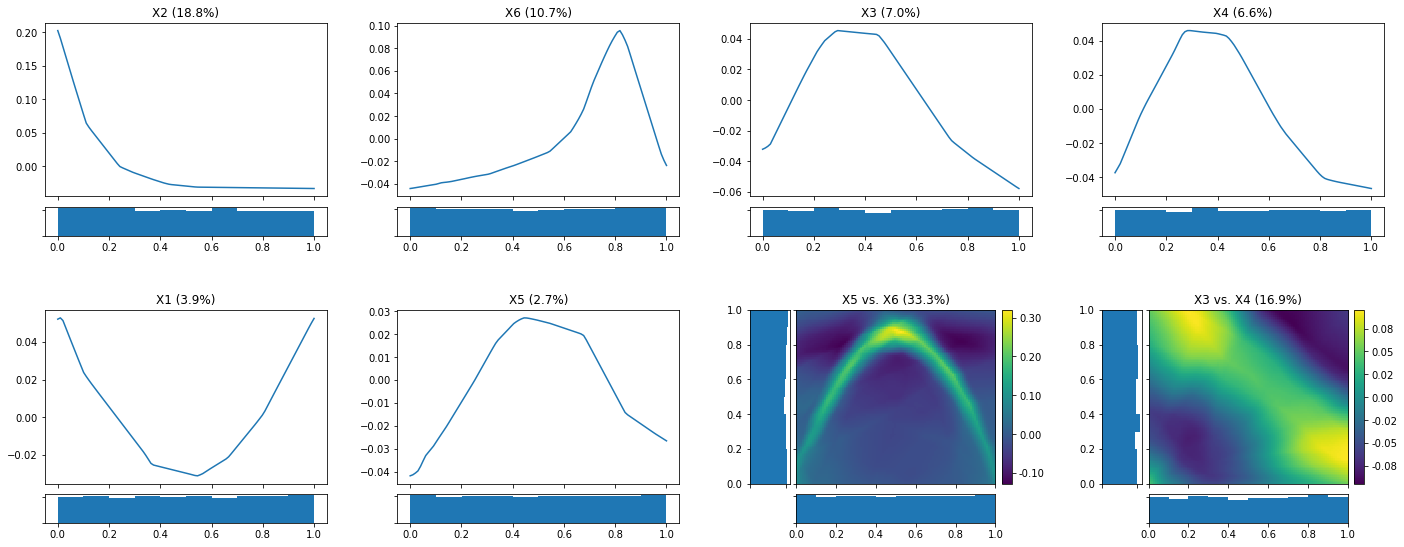

In [6]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=True, folder=simu_dir, name='s1_global')

Feature Importance

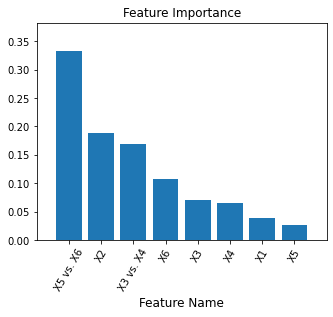

In [7]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [8]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

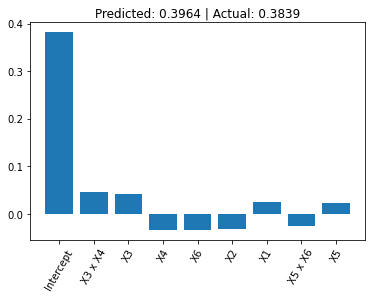

In [9]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

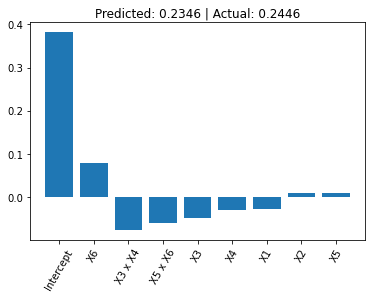

In [10]:
local_visualize(data_dict_local[1], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [11]:
model.save(folder="./", name="model_saved")

In [12]:
## The reloaded model should not be refit again
modelnew = GAMINet(meta_info={})
modelnew.load(folder="./", name="model_saved")

# Shape constraints

In [46]:
model_debug = GAMINet(meta_info=meta_info, interact_num=0, 
                interact_arch=[40] * 5, subnet_arch=[40] * 5, 
                batch_size=200, task_type=task_type, activation_func=tf.nn.relu, 
                main_effect_epochs=500, interaction_epochs=500, tuning_epochs=500, 
                lr_bp=[0.01, 0.0001, 0.0001], early_stop_thres=[50, 50, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                convex_list=[0, 1],
                mono_decreasing_list=[1], lattice_size=2,
                include_interaction_list=[(2, 3), (4, 5)],
                # manually inputted interactions are included in addition to prescreening interactions defined by interact_num.
                ## Model with Convexity Constraints are generally hard to train, try larger learning rates.
                verbose=True, val_ratio=0.2, random_state=random_state)
model_debug.fit(train_x, train_y)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.02050, val loss: 0.02065
Main effects training epoch: 2, train loss: 0.01853, val loss: 0.01872
Main effects training epoch: 3, train loss: 0.01710, val loss: 0.01775
Main effects training epoch: 4, train loss: 0.01471, val loss: 0.01532
Main effects training epoch: 5, train loss: 0.01366, val loss: 0.01416
Main effects training epoch: 6, train loss: 0.01349, val loss: 0.01391
Main effects training epoch: 7, train loss: 0.01285, val loss: 0.01337
Main effects training epoch: 8, train loss: 0.01248, val loss: 0.01266
Main effects training epoch: 9, train loss: 0.01299, val loss: 0.01328
Main effects training epoch: 10, train loss: 0.01239, val loss: 0.01268
Main effects training epoch: 11, train loss: 0.01242, val loss: 0.01270
Main effects training epoch: 12, train loss: 0.01232, val loss: 0.01259
Main effects training e

Main effects training epoch: 114, train loss: 0.01166, val loss: 0.01146
Main effects training epoch: 115, train loss: 0.01194, val loss: 0.01193
Main effects training epoch: 116, train loss: 0.01162, val loss: 0.01158
Main effects training epoch: 117, train loss: 0.01144, val loss: 0.01151
Main effects training epoch: 118, train loss: 0.01120, val loss: 0.01110
Main effects training epoch: 119, train loss: 0.01148, val loss: 0.01136
Main effects training epoch: 120, train loss: 0.01124, val loss: 0.01110
Main effects training epoch: 121, train loss: 0.01115, val loss: 0.01109
Main effects training epoch: 122, train loss: 0.01136, val loss: 0.01121
Main effects training epoch: 123, train loss: 0.01168, val loss: 0.01161
Main effects training epoch: 124, train loss: 0.01143, val loss: 0.01151
Main effects training epoch: 125, train loss: 0.01128, val loss: 0.01125
Main effects training epoch: 126, train loss: 0.01169, val loss: 0.01166
Main effects training epoch: 127, train loss: 0.011

Interaction training epoch: 96, train loss: 0.00488, val loss: 0.00485
Interaction training epoch: 97, train loss: 0.00489, val loss: 0.00487
Interaction training epoch: 98, train loss: 0.00488, val loss: 0.00483
Interaction training epoch: 99, train loss: 0.00485, val loss: 0.00481
Interaction training epoch: 100, train loss: 0.00482, val loss: 0.00480
Interaction training epoch: 101, train loss: 0.00482, val loss: 0.00479
Interaction training epoch: 102, train loss: 0.00483, val loss: 0.00481
Interaction training epoch: 103, train loss: 0.00480, val loss: 0.00477
Interaction training epoch: 104, train loss: 0.00478, val loss: 0.00473
Interaction training epoch: 105, train loss: 0.00477, val loss: 0.00474
Interaction training epoch: 106, train loss: 0.00475, val loss: 0.00470
Interaction training epoch: 107, train loss: 0.00472, val loss: 0.00468
Interaction training epoch: 108, train loss: 0.00477, val loss: 0.00474
Interaction training epoch: 109, train loss: 0.00468, val loss: 0.00

Interaction training epoch: 210, train loss: 0.00270, val loss: 0.00275
Interaction training epoch: 211, train loss: 0.00276, val loss: 0.00275
Interaction training epoch: 212, train loss: 0.00269, val loss: 0.00271
Interaction training epoch: 213, train loss: 0.00266, val loss: 0.00271
Interaction training epoch: 214, train loss: 0.00265, val loss: 0.00269
Interaction training epoch: 215, train loss: 0.00266, val loss: 0.00266
Interaction training epoch: 216, train loss: 0.00267, val loss: 0.00273
Interaction training epoch: 217, train loss: 0.00268, val loss: 0.00272
Interaction training epoch: 218, train loss: 0.00266, val loss: 0.00270
Interaction training epoch: 219, train loss: 0.00271, val loss: 0.00276
Interaction training epoch: 220, train loss: 0.00264, val loss: 0.00270
Interaction training epoch: 221, train loss: 0.00265, val loss: 0.00272
Interaction training epoch: 222, train loss: 0.00259, val loss: 0.00263
Interaction training epoch: 223, train loss: 0.00259, val loss: 

Interaction training epoch: 324, train loss: 0.00217, val loss: 0.00226
Interaction training epoch: 325, train loss: 0.00215, val loss: 0.00223
Interaction training epoch: 326, train loss: 0.00219, val loss: 0.00226
Interaction training epoch: 327, train loss: 0.00219, val loss: 0.00226
Interaction training epoch: 328, train loss: 0.00216, val loss: 0.00225
Interaction training epoch: 329, train loss: 0.00226, val loss: 0.00236
Interaction training epoch: 330, train loss: 0.00218, val loss: 0.00224
Interaction training epoch: 331, train loss: 0.00221, val loss: 0.00231
Interaction training epoch: 332, train loss: 0.00219, val loss: 0.00228
Interaction training epoch: 333, train loss: 0.00219, val loss: 0.00226
Interaction training epoch: 334, train loss: 0.00214, val loss: 0.00222
Interaction training epoch: 335, train loss: 0.00219, val loss: 0.00229
Interaction training epoch: 336, train loss: 0.00216, val loss: 0.00225
Interaction training epoch: 337, train loss: 0.00222, val loss: 

Interaction training epoch: 438, train loss: 0.00216, val loss: 0.00228
Interaction training epoch: 439, train loss: 0.00210, val loss: 0.00219
Interaction training epoch: 440, train loss: 0.00211, val loss: 0.00221
Interaction training epoch: 441, train loss: 0.00208, val loss: 0.00217
Interaction training epoch: 442, train loss: 0.00209, val loss: 0.00217
Interaction training epoch: 443, train loss: 0.00211, val loss: 0.00220
Interaction training epoch: 444, train loss: 0.00211, val loss: 0.00221
Interaction training epoch: 445, train loss: 0.00210, val loss: 0.00219
Interaction training epoch: 446, train loss: 0.00209, val loss: 0.00219
Interaction training epoch: 447, train loss: 0.00209, val loss: 0.00219
Interaction training epoch: 448, train loss: 0.00211, val loss: 0.00220
Interaction training epoch: 449, train loss: 0.00210, val loss: 0.00219
Interaction training epoch: 450, train loss: 0.00209, val loss: 0.00218
Interaction training epoch: 451, train loss: 0.00216, val loss: 

Fine tuning epoch: 60, train loss: 0.00203, val loss: 0.00213
Fine tuning epoch: 61, train loss: 0.00210, val loss: 0.00223
Fine tuning epoch: 62, train loss: 0.00202, val loss: 0.00212
Fine tuning epoch: 63, train loss: 0.00204, val loss: 0.00217
Fine tuning epoch: 64, train loss: 0.00207, val loss: 0.00218
Fine tuning epoch: 65, train loss: 0.00209, val loss: 0.00222
Fine tuning epoch: 66, train loss: 0.00200, val loss: 0.00211
Fine tuning epoch: 67, train loss: 0.00202, val loss: 0.00213
Fine tuning epoch: 68, train loss: 0.00202, val loss: 0.00213
Fine tuning epoch: 69, train loss: 0.00207, val loss: 0.00217
Fine tuning epoch: 70, train loss: 0.00199, val loss: 0.00211
Fine tuning epoch: 71, train loss: 0.00206, val loss: 0.00215
Fine tuning epoch: 72, train loss: 0.00204, val loss: 0.00217
Fine tuning epoch: 73, train loss: 0.00207, val loss: 0.00220
Fine tuning epoch: 74, train loss: 0.00205, val loss: 0.00215
Fine tuning epoch: 75, train loss: 0.00201, val loss: 0.00214
Fine tun

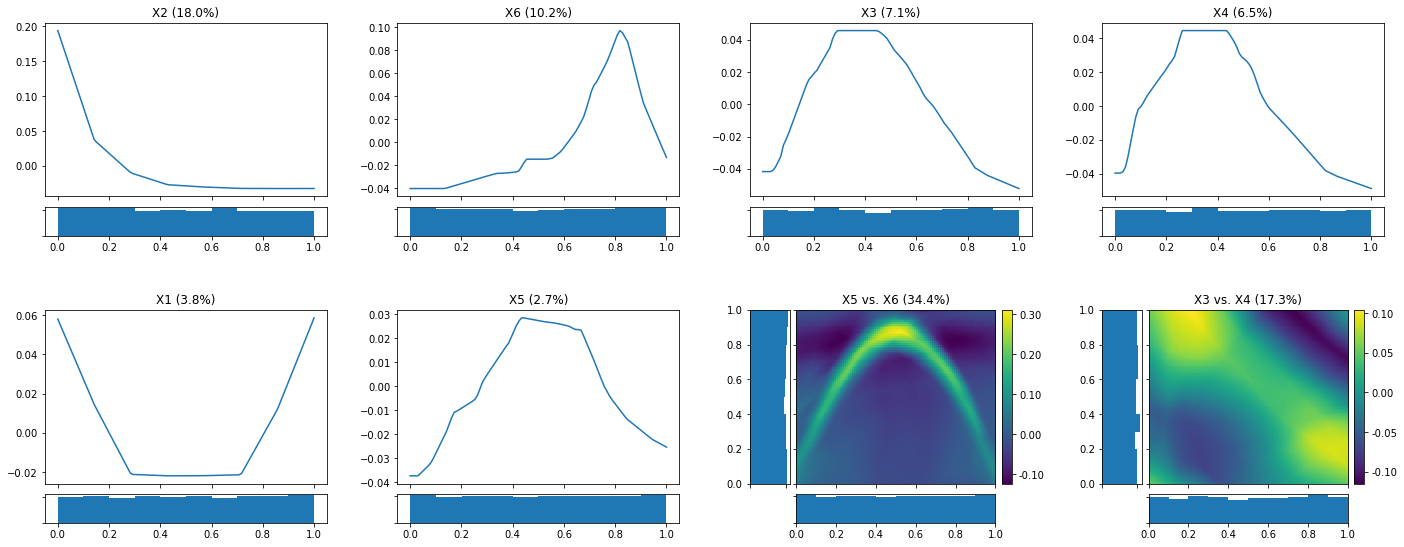

In [47]:
# The interactions are also constrained to be convex or concave, which is very different from the ground truth.
# (Decreased Predictive Performance)

data_dict_global = model_debug.global_explain(save_dict=False)
global_visualize_density(data_dict_global, save_png=False)

In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [34]:
# Generate a simple time series dataset
X_Train = np.sin(0.14*np.array([i for i in range(1000)])*np.pi)+0.1*np.random.rand(1000)
X_Train[:5]

X_Test = np.cos(0.14*np.array([i for i in range(1000)])*np.pi)
X_Test[:5]


array([ 1.        ,  0.90482705,  0.63742399,  0.24868989, -0.18738131])

In [41]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)):
        end_ix = i + n_steps
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Define the number of previous time steps to use as input
n_steps = 3
X_Tr, y_Tr = create_sequences(X_Train, n_steps)
X_Ts, y_Ts = create_sequences(X_Test, n_steps)
print(X_Tr[:5])
# Reshape from [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X_Tr = X_Tr.reshape((X_Tr.shape[0], X_Tr.shape[1], n_features))
X_Ts = X_Ts.reshape((X_Ts.shape[0], X_Ts.shape[1], n_features))


[[3.62508221e-04 4.55858214e-01 7.77379848e-01]
 [4.55858214e-01 7.77379848e-01 9.72278102e-01]
 [7.77379848e-01 9.72278102e-01 1.03035977e+00]
 [9.72278102e-01 1.03035977e+00 8.41561004e-01]
 [1.03035977e+00 8.41561004e-01 5.35557197e-01]]


In [36]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


c:\Users\Giwa\.conda\envs\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
model.fit(X_Tr, y_Tr, epochs=200, verbose=0)


In [43]:
x_input = np.array([97, 98, 99])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(X_Ts, verbose=0)
print(yhat)


[[ 0.2660366 ]
 [-0.1662204 ]
 [-0.56793034]
 [-0.85015124]
 [-0.9805058 ]
 [-0.9227956 ]
 [-0.6530418 ]
 [-0.32751805]
 [ 0.1089375 ]
 [ 0.532595  ]
 [ 0.8675563 ]
 [ 0.9957952 ]
 [ 0.9699088 ]
 [ 0.75827074]
 [ 0.38764283]
 [-0.04503229]
 [-0.4598045 ]
 [-0.788063  ]
 [-0.96969384]
 [-0.9551873 ]
 [-0.73967576]
 [-0.4367229 ]
 [-0.02024439]
 [ 0.41450095]
 [ 0.7909223 ]
 [ 0.96775717]
 [ 1.003554  ]
 [ 0.8391969 ]
 [ 0.503551  ]
 [ 0.07724021]
 [-0.34265578]
 [-0.71004844]
 [-0.9383411 ]
 [-0.97253424]
 [-0.82459575]
 [-0.53375375]
 [-0.14669468]
 [ 0.30010936]
 [ 0.6948004 ]
 [ 0.9363992 ]
 [ 1.0195336 ]
 [ 0.9014762 ]
 [ 0.6123698 ]
 [ 0.20311819]
 [-0.22571816]
 [-0.6187874 ]
 [-0.88327765]
 [-0.98170197]
 [-0.8975426 ]
 [-0.6170143 ]
 [-0.26922715]
 [ 0.17414002]
 [ 0.5885486 ]
 [ 0.89834875]
 [ 1.0067836 ]
 [ 0.9486057 ]
 [ 0.7131891 ]
 [ 0.3274371 ]
 [-0.1059036 ]
 [-0.51464856]
 [-0.8191611 ]
 [-0.9774294 ]
 [-0.94146365]
 [-0.6933011 ]
 [-0.38353455]
 [ 0.04376066]
 [ 0.47446